In [31]:
from matplotlib import pyplot as plt
import matplotlib
import numpy as np

from matplotlib.pyplot import figure

def group_data(lines: [str]) -> [str]:
    result = {}

    for line in lines:
        parts = line.split(',')
        if parts[0] in result:
            result[parts[0]].append((int(parts[1]), int(parts[2])))
        else:
            result[parts[0]] = [(int(parts[1]), int(parts[2]))]

    return result

geth_evm_go_benchmarks = None
with open("benchmarks-results/geth-evm-go.csv") as f:
    geth_evm_go_benchmarks = group_data(f.readlines())

geth_evm_asm384_benchmarks = None
with open('benchmarks-results/geth-evm-asm384.csv') as f:
    geth_evm_asm384_benchmarks = group_data(f.readlines())

go_arith_benchmarks = None
with open("benchmarks-results/go-arith-benchmarks.csv") as f:
    go_arith_benchmarks = group_data(f.readlines())

def scatterplot_ns_data(name: str, annotate: bool, *args):
    
    x_min_all = min([min([v[0] for v in d]) for (d, _, _) in args])
    x_max_all = max([max([v[0] for v in d]) for (d, _, _) in args])
    y_min_all = min([min([v[1] for v in d]) for (d, _, _) in args])
    y_max_all = max([max([v[1] for v in d]) for (d, _, _) in args])
    span_x = x_max_all - x_min_all
    span_y = y_max_all - y_min_all

    plt.rcParams["figure.figsize"] = (20, 10)
    fig, ax = plt.subplots()
    plt.ylim(0, y_min_all + span_y * 1.2)
    plt.xlim(0, x_min_all + span_x * 1.2)

    for (data, color, label) in args:
        # Map each onto a scatterplot we'll create with Matplotlib
        #ax.scatter(x=x, y=y, c=scale, s=np.abs(scale)*500)
        mulmont_x = [val[0] for val in data]
        mulmont_y = [val[1] for val in data]

        assert len(mulmont_x) == len(mulmont_y)
        span = max(mulmont_y) - min(mulmont_y)

        plt.xlabel("number of limbs")
        plt.ylabel("runtime (ns)")
        
        if annotate:
            for x, y in zip(mulmont_x, mulmont_y):
                ax.annotate(y, (float(x) + 0.2, float(y)))

        ax.plot(mulmont_x, mulmont_y, 'o', color=color, label=label)
    plt.legend(loc="upper left")
    ax.set(title=name)
    plt.show()

## Abstract
We introduce new EVM opcodes for performing modular addition, subtraction and Montgomery multiplication in the EVM.

## Motivation

The EVM has `ADDMOD` and `MULMOD` opcodes to perform modular arithmetic.  Both of these opcodes require passing the inputs and modulus as stack values for each invocation and `MULMOD` must perform an expensive division.  In addition, they are capped to values that fit in 256-bit widths.

Montgomery multiplication (`montmul`) is a method for performing modular multiplication without division.  `montmul` requires precomputation of a modulus-specific constant `modinv`.  Values must be converted to Montgomery form to use `montmul` (and converted to their normal form later).  This costs a single `montmul` per conversion.

Modular addition/subtraction for values in Montgomery form is unchanged from normal form.

This EIP introduces new opcodes for multiprecision modular addition, subtraction and Montgomery multiplication that expand the range of crypto algorithms that can realistically be implemented as EVM contracts.

## Specification

Introduce four opcodes: `SETMODMAX` (0xc)` ADDMODMAX` (0xd), `SUBMODMAX` (0xe), `MULMONTMAX` (0xf).

`ADDMODMAX`, `SUBMODMAX` and `MULMONTMAX` respectively perform modular addition, subtraction and Montgomery multiplication.

`SETMODMAX` is used to set the modulus used for arithmetic opcodes, precompute a modulus-specific constant used by `montmul` and associate these with the current call context.

```
# size of each limb in bytes
LIMB_SIZE = 8

# maximum value representable by a limb + 1
LIMB_BASE = 1<<64
```

#### `SETMODMAX`

`SETMODMAX` takes a stack argument with parameters encoded in the first two bytes: `modSize`, `modOffset`.

If `modSize` is 0 or greater than 7, halt execution in an exceptional state and return to the calling frame.

If memory size is less than `modOffset + modSize * LIMB_SIZE`, halt execution in an exceptional state and return to the calling frame.  Otherwise, the modulus is loaded from `evm_memory[modOffset:modOffset + modSize * 8]` and interpreted as a little-endian array of 64-bit unsigned integers.

Assert that the modulus is odd, and return execution to the parent in an exceptional state if not.

`SETMODMAX` then computes a modulus-specific constant used for Montgomery multiplication and associates it and the modulus with the current call context.  For Montgomery multiplication algorithms operating at smaller widths, this is usually `pow(-modulus, -1, LIMB_BASE)`.

#### Arithmetic Opcodes

`ADDMODMAX` `SUBMODMAX` and `MULMONTMAX` take a single stack element as input.  The first three bytes of the input, are denoted `out_offset`, `x_offset`, `y_offset`.

Each offset refers to a contiguous slot of evm memory `[offset*elem_size_bytes:offset*elem_size_bytes + elem_size_bytes]` which is interpreted as a little-endian number composed of 64-bit limbs.  EVM memory expansion cost is charged through the last byte of the highest slot.

If `x` or `y` are greater than or equal to the modulus, halt execution in exceptional state and return to the calling frame.

`ADDMODMAX` computes `(x + y) % mod` and places the result at the memory specified by `out_offset`.

`SUBMODMAX` computes `(x - y) % mod` and places the result at the memory specified by `out_offset`.

`MULMONTMAX` computes the Montgomery multiplication of `x` and `y` (`montmul(x,y)`) and places it at the memory slot specified by `out_offset`.  Given an odd modulus `mod` which would occupy `limb_count` number of limbs, a number `R = 1 << (limb_count * 64)`, then `montmul(x,y) = (x * y * pow(R, -1, mod)) % mod`

#### Costs

TBD

## Rationale

* choice of little-endian limbs made to match the hardware, removing the need for endianness-swapping individual limbs.
* choice of input encoding as single-bytes which map to "slots" in the memory space was made to reduce bytecode size while providing enough flexibility for users to implement various crypto applications.

### Benchmarks

To estimate performance of the arithmetic opcodes, I developed standalone EVM benchmarks which estimate EVMMAX arithmetic opcode performance at various limb counts using inputs that have worst-case performance.  These benchmarks consist of a setup (placing modulus/input values in memory, calling `SETMOD`), and a large loop which performs 5000 operations for 255 iterations.

Each invocation is of the form `PUSH3 {result offset byte}{x offset byte}{y offset byte} + EVMMAX_ARITH_OP`.

To measure the overhead of `PUSH3`, a separate benchmark which consists of a loop of `PUSH3 000000 POP` with the same number of invocations as the number EVMMAX ops in the EVMMAX benchmark.

The runtime of the `PUSH3_POP` benchmark is subtracted from the `EVMMAX_OP` benchmark and divided by the number of EVMMAX operation invocations to estimate a runtime for a given number of limbs.  The cost of the setup is amortized by the main loop of each benchmark.

The below graphs plot the estimated runtime of EVMMAX ops alongside performance of standalone arithmetic benchmarks with the same worst-case inputs applied.  EVM benchmarks for `SETMOD` are omitted because EVM interpreter overhead is insignificant compared to the cost of the arithmetic.


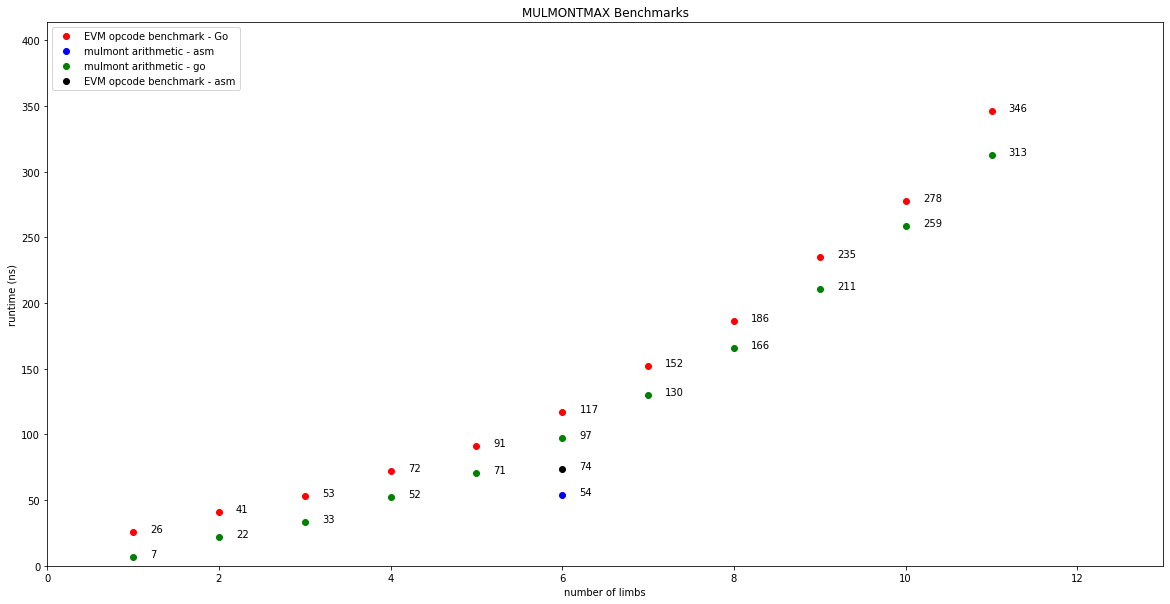

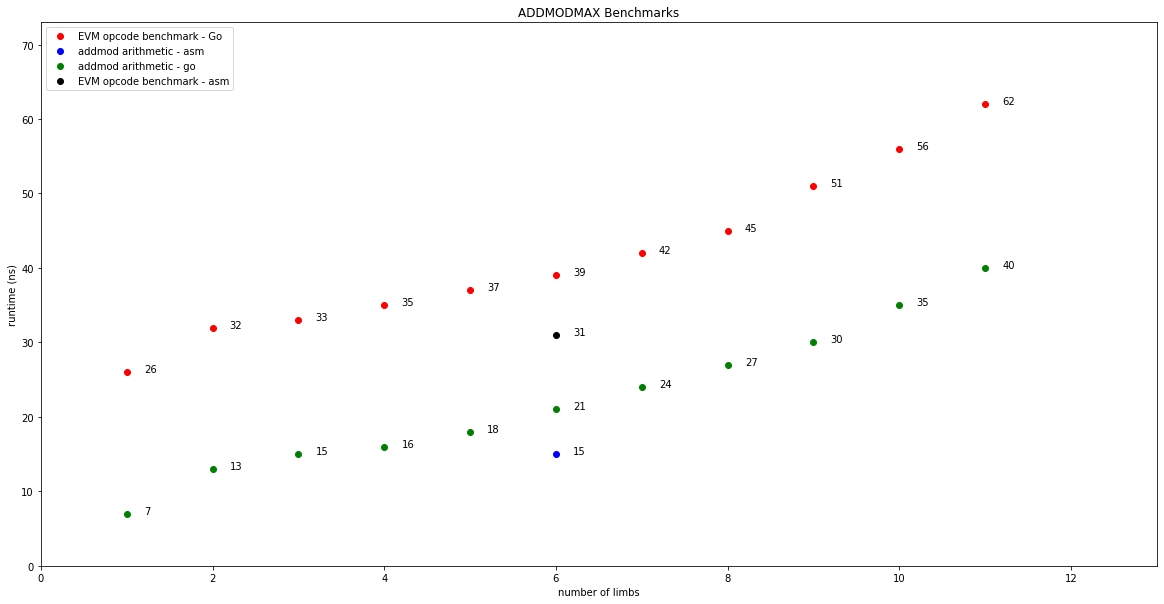

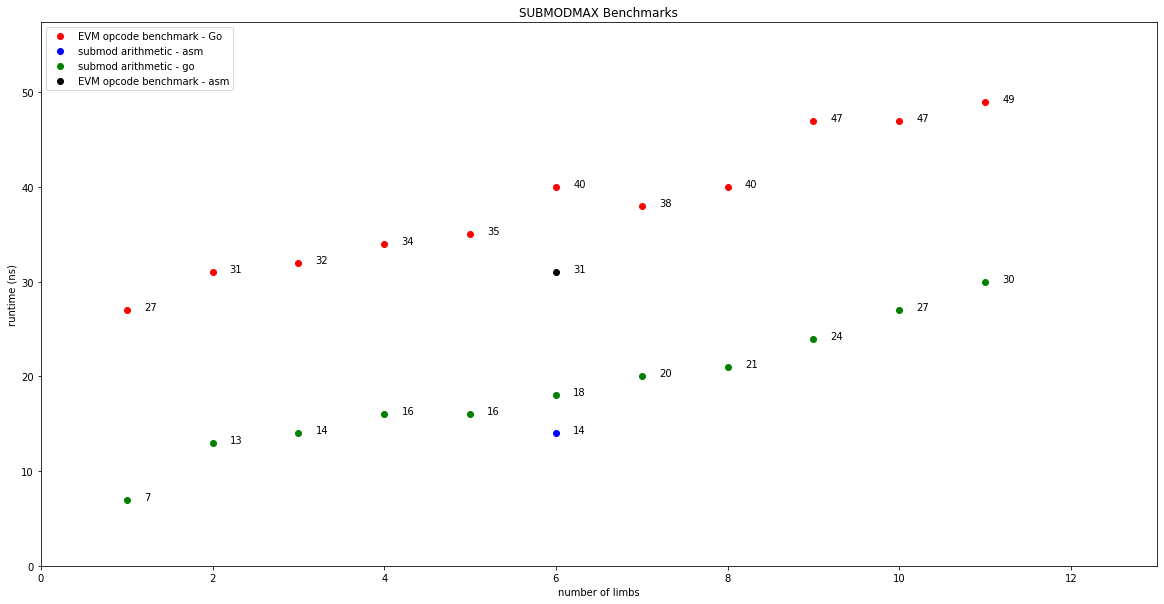

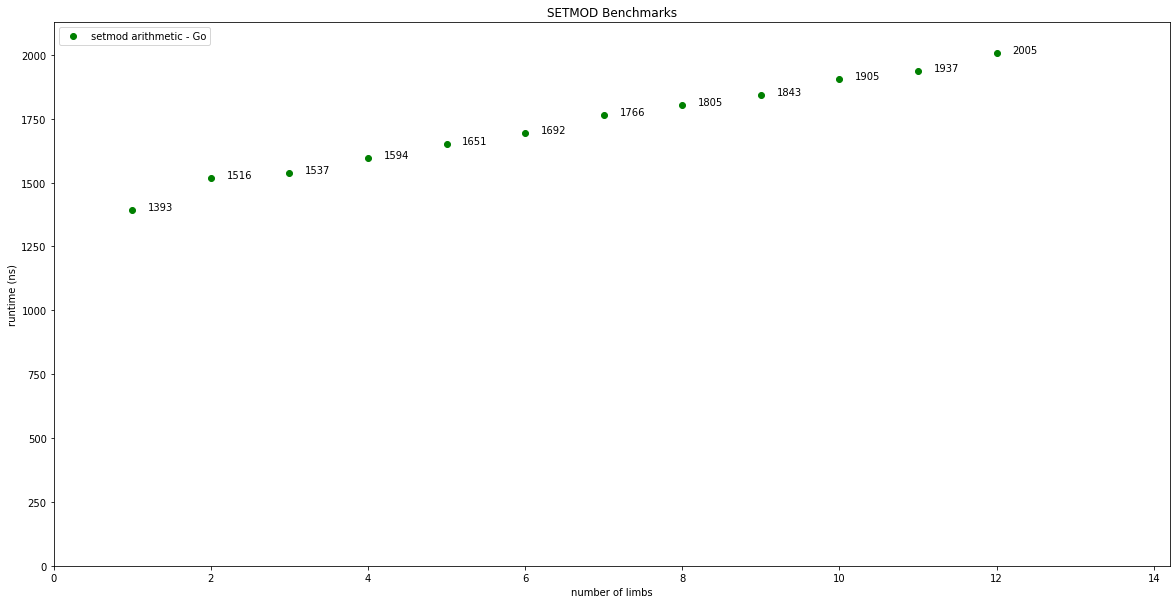

In [32]:
scatterplot_ns_data("MULMONTMAX Benchmarks", True, (geth_evm_go_benchmarks['MULMONTMAX'][:11], "red", "EVM opcode benchmark - Go" ),
                                                    (go_arith_benchmarks['MulMontAsm'], "blue", "mulmont arithmetic - asm"),
                                                    (go_arith_benchmarks['MulMontGo'][:11], "green", "mulmont arithmetic - go"),
                                                    (geth_evm_asm384_benchmarks['MULMONTMAX'], "black", "EVM opcode benchmark - asm"))


scatterplot_ns_data("ADDMODMAX Benchmarks", True, (geth_evm_go_benchmarks['ADDMODMAX'][:11], "red", "EVM opcode benchmark - Go" ),
                                                    (go_arith_benchmarks['AddModAsm'], "blue", "addmod arithmetic - asm"),
                                                    (go_arith_benchmarks['AddModGo'][:11], "green", "addmod arithmetic - go"),
                                                    (geth_evm_asm384_benchmarks['ADDMODMAX'], "black", "EVM opcode benchmark - asm"))

scatterplot_ns_data("SUBMODMAX Benchmarks", True, (geth_evm_go_benchmarks['SUBMODMAX'][:11], "red", "EVM opcode benchmark - Go" ),
                                                    (go_arith_benchmarks['SubModAsm'], "blue", "submod arithmetic - asm"),
                                                    (go_arith_benchmarks['SubModGo'][:11], "green", "submod arithmetic - go"),
                                                    (geth_evm_asm384_benchmarks['SUBMODMAX'], "black", "EVM opcode benchmark - asm"))

#scatterplot_ns_data("ADDMODMAX Benchmarks", True, (geth_evm_evmmax_benchmarks['ADDMODMAX'][:-1], "red", "opcode benchmark - Go" ),
#                                                    (go_arith_evmmax_benchmarks['AddMod'][:-2], "green", "mulmont only - Go"),
#                                                    (go_arith_asm384_benchmarks['AddMod'], "blue", "mulmont only - asm"),
#                                                    (geth_evm_asm384_benchmarks['ADDMODMAX'], "black", "opcode benchmark - asm"))

#scatterplot_ns_data("SUBMODMAX Benchmarks", True, (geth_evm_evmmax_benchmarks['SUBMODMAX'][:-1], "red", "opcode benchmark - Go" ),
#                                                    (go_arith_evmmax_benchmarks['SubMod'][:-2], "green", "mulmont only - Go"),
#                                                    (go_arith_asm384_benchmarks['SubMod'], "blue", "mulmont only - asm"),
#                                                    (geth_evm_asm384_benchmarks['SUBMODMAX'], "black", "opcode benchmark - asm"))

scatterplot_ns_data("SETMOD Benchmarks", True, (go_arith_benchmarks['SetMod'], "green", "setmod arithmetic - Go"))


#### Python Arithmetic Implementation


```

# -----------------------------------------------------------------------------
#   start of `limbs` bignum utility code
#   express numbers as little-endian lists of values of base `base`

def limbs_sub(x: [int], y: [int], base: int) -> [int]:
    assert len(x) == len(y), "num_limbs must be equal"
    num_limbs = len(x)
    res = [0] * num_limbs
    b = 0

    result = limbs_to_num(x, base) - limbs_to_num(y, base)
    return num_to_limbs(abs(result), base, len(x))

    # for i, (x, y) in enumerate(zip(x, y)):
    #     res[i] = abs(x - y - c) % base
    #     c =  abs(x - y - c) // base

    # return c, res

# add two equally-sized numbers together.
# return a carry/overflow limb and the sum limbs
def limbs_add(x: [int], y: [int], base) -> (int, [int]):
    assert len(x) == len(y), "num_limbs must be equal"

    res = [0] * len(x)

    c = 0
    for i, (x, y) in enumerate(zip(x, y)):
        res[i] = (x + y + c) % base
        c =  (x + y + c) // base

    return c, res

# given two equally-sized, multiple-limb numbers x, y: return x >= y
def limbs_gte(x, y) -> bool:
    assert len(x) == len(y), "x and y should have same number of limbs"
    
    for (x_limb, y_limb) in reversed(list(zip(x,y))):
        if x_limb > y_limb:
            return True
        elif x_limb < y_limb:
            return False

    return True

# TODO assert that the number can actually be represented by `limb_count` limbs
def num_to_limbs(num, base, limb_count=None) -> [int]:
    res = []

    if limb_count != None:
        for _ in range(limb_count):
            res.append(num % base)
            num //= base
    else:
        while num != 0:
            res.append(num % base)
            num //= base

    return res

def limbs_to_num(limbs, base) -> [int]:
    res = 0

    for i, limb in enumerate(limbs):
        res += limb * (base ** i)

    return res

LIMB_BITS = 64

def hi_lo(double_word: int, word_size: int) -> (int, int):
    assert val < (1<<(word_size * 8 * 2)), "val must fit in two words"
    base = 1 << (word_size * 8)
    return (val >> (word_size * 8)) % base, val % base

# -----------------------------------------------------------------------------
# start of arithmetic

# implementation adapted from section 2.3.2 in https://www.microsoft.com/en-us/research/wp-content/uploads/1998/06/97Acar.pdf
# mulmont_cios computes (x * y * pow(R, -1, mod)) % mod, where R = 1 << (limb_count * word_size * 8)
# modinv must be pow(-mod, -1, 1 << (word_size * 8))
def mulmont_cios(x, y, mod, modinv, word_size) -> [int]:
    assert len(x) == len(y) and len(y) == len(mod), "bignum inputs must have same length"
    assert mod[-1] != 0, "modulus must occupy all limbs"

    limb_count = len(mod)

    t = [0] * (limb_count + 2)

    for i in range(limb_count):
        # first inner-loop multiply x * y[i]
        c = 0 
        for j in range(limb_count):
            c, t[j] = hi_lo(t[j] + x[j] * y[i] + c, word_size)

        t[limb_count + 1], t[limb_count] = hi_lo(t[limb_count] + c, word_size)

        m = (modinv * t[0]) % (1 << (word_size * 8)) 
        c, _ = hi_lo(m * mod[0] + t[0], word_size)

        # second inner-loop: reduction.
        for j in range(1, limb_count):
            c, t[j - 1] = hi_lo(t[j] + mod[j] * m + c, word_size)

        hi, t[limb_count - 1] = hi_lo(t[limb_count] + c, word_size)
        t[limb_count] = t[limb_count + 1] + hi

    t = t[:-1]
    if t[-1] != 0:
        return limbs_sub(t, mod + [0], 1<<64)[:-1]
    elif limbs_gte(t[:-1], mod):
        return limbs_sub(t[:-1], mod, 1<<64)

# addmod computes (x + y) % mod
def addmod(x: [int], y: [int], mod: [int], word_size: int) -> [int]:
    assert len(x) == len(y) and len(y) == len(mod), "bignum inputs must have same length"
    limb_count = len(mod)

    # TODO add a more "realistic" implementation of addmod here (similar to the Go code)
    return int_to_limbs((limbs_to_int(x) + limbs_to_int(y)) % limbs_to_int(mod), limb_count)
    

# submod computes (x - y) % mod
def submod(x: [int], y: [int], mod: [int], word_size: int) -> [int]:
    assert len(x) == len(y) and len(y) == len(mod), "bignum inputs must have same length"

    # TODO add a more "realistic" implementation of submod here (similar to the Go code)
    return int_to_limbs((limbs_to_int(x) - limbs_to_int(y)) % limbs_to_int(mod), limb_count)

# setmod computes a modulus-specific constant used by the CIOS algorithm (and also some other algorithms that operate at small bit-widths)
def setmod(mod: [int], word_size: int) -> int:
    return pow(-mod, -1, 1 << (word_size * 8))
    
# -----------------------------------------------------------------------------
# start of test cases

MAX_LIMB_COUNT = 12
LIMB_BITS = 64
WORD_SIZE = 8

for limb_count in range(1, MAX_LIMB_COUNT):
    # test that mulmont_cios(mod - 1, mod - 1, max_mod, modinv) == (mod - 1) * (mod - 1) * pow(1 << (limb_count * LIMB_BITS), -1, mod)
    max_mod = int_to_limbs((1 << (limb_count * 64)) - 1)
    modinv = setmod(max_mod, WORD_SIZE)
    
    x = int_to_limbs(max_mod - 1, WORD_SIZE)
    y = int_to_limbs(max_mod - 1, WORD_SIZE)
    assert limbs_to_int(mulmont_cios(x, y, max_mod, modinv, WORD_SIZE)) == (mod - 1) * (mod - 1) * pow(1 << (limb_count * LIMB_BITS), -1, mod)
```

## Backwards Compatibility

There are no backwards-compatibility concerns for the changes introduced in this EIP.

## Test Cases
TBD

## Reference Implementation
* TODO link to my geth branch

## Security Considerations
* TODO?